In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import torch 
import torch.nn as nn 
import tiktoken 
from GPT.Tokenization import text_to_tokens, token_to_text
from GPT.LLM_Pre_Training_Loop import train_model
from GPT.GPT_Model import GPTModel

import json
with open("../GPT_Model_Configuration/GPT_config_124M.json", "r") as f:
    GPT_CONFIG_124M = json.load(f)

In [3]:
tokenizer = tiktoken.get_encoding("gpt2")

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
import os
with open("C:\\Users\\hites\\OneDrive\\Desktop\\GPT\\data\\the-verdict.txt", 'r', encoding='utf-8')  as f:
    raw_text = f.read()

In [6]:
# Train / Validation ratio 
train_ratio = 0.80 
split_idx = int(train_ratio * len(raw_text))
train_data = raw_text[:split_idx]
val_data = raw_text[split_idx:]

In [7]:
from GPT.Dataset_and_DataLoaders import create_dataloader_v1, GPTDataset
train_loader = create_dataloader_v1(
    train_data, 
    batch_size=2, 
    max_length=GPT_CONFIG_124M["context_length"], 
    stride=GPT_CONFIG_124M["context_length"], 
    drop_last=True, 
    shuffle=True, 
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data, 
    batch_size=2, 
    max_length=GPT_CONFIG_124M["context_length"], 
    stride=GPT_CONFIG_124M["context_length"], 
    drop_last=False,  
    shuffle=False, 
    num_workers=0
)

In [8]:
GPT_CONFIG_124M

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': True}

In [9]:
print(len(val_loader))

1


In [10]:
import time 
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device=device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10 
train_losses, val_losses, tokens_seen = train_model(
    model=model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, num_epochs=num_epochs, eval_freq=5, eval_iter=5, 
    start_context="Every effort moves you", tokenizer=tokenizer

)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 (Step: 000000) | Train Loss: 9.584 | Val Loss: 9.953


 10%|█         | 1/10 [01:23<12:32, 83.63s/it]

Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


 20%|██        | 2/10 [02:29<09:45, 73.17s/it]

Every effort moves you, the,,,,,,,,,,, the,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Epoch: 3 (Step: 000005) | Train Loss: 7.291 | Val Loss: 8.106


 30%|███       | 3/10 [03:48<08:50, 75.76s/it]

Every effort moves you, the,,,,,,,,,,, the,,,,,,,,,,,,,,, the,,,,,,,,,,,,,,,, the,,,


 40%|████      | 4/10 [04:53<07:08, 71.50s/it]

Every effort moves you, and, and of the of the, and, and, and.                                   


 50%|█████     | 5/10 [06:20<06:25, 77.04s/it]

Every effort moves you, and, and, and, and, and, and, and, and, and of the, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and
Epoch: 6 (Step: 000010) | Train Loss: 5.260 | Val Loss: 7.339


 60%|██████    | 6/10 [08:12<05:56, 89.07s/it]

Every effort moves you--as, and of the a of the--and--and the of the--, and of the--and. Gisburn, and of the of the, and. I had been. Gisburn's a, and. Gis


 70%|███████   | 7/10 [10:18<05:03, 101.08s/it]

Every effort moves you--as, and he was a of his--and a of the picture--and, and had been, and I had been, and I had been, and I had been. Gisburn's ", and I had been. Gis
Epoch: 8 (Step: 000015) | Train Loss: 3.738 | Val Loss: 6.897


 80%|████████  | 8/10 [11:41<03:10, 95.43s/it] 

Every effort moves you know, I had been the a of his pictures--and I had been the picture--as, I had been the picture--as, in the picture of a, with a.             


 90%|█████████ | 9/10 [12:43<01:25, 85.03s/it]

Every effort moves you--as I was his pictures--and it--and the picture--and--and it was no--and I had been his pictures--and the picture--and it was not.             


100%|██████████| 10/10 [13:46<00:00, 82.64s/it]

Every effort moves you know," was his pictures--as he said--and the picture the house of the his pictures--and it to me to have been to me to me it was not to have been his pictures--and of the a little, and he had been
Training completed in 13.85 minutes.


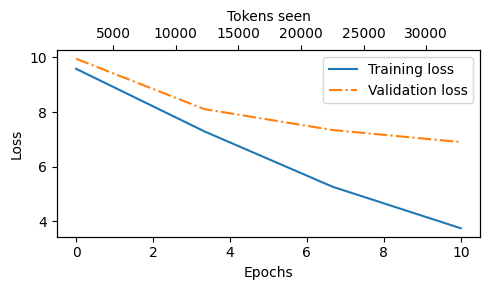

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)